In [1]:
# Importing all necessary python libraries and packages
import joblib               # Loads and saves a serializable python object
import numpy as np          # Performs mathemtical operations with arrays and matrices
import pandas as pd         # Loads data to dataframe after reading data files
from tqdm import tqdm       # Visualizes iterating through an iterable object
from time import time       # Used to keep track of time elapsed

# All tensorflow modules and layers are imported below
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, \
    Flatten, concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.optimizers import Nadam

We first specify some of the common parameters that we will use throughout the notebook

In [2]:
MAX_CHAR_LEN = 52           # Maximum length of words that we consider. 52 has been choosen after analyzing the words in the dataset
GloVe_emb_dim = 50          # Dimension of GloVe embeddings that we use in our model (More about gloVe embeddings: https://nlp.stanford.edu/projects/glove/)
glove_embeddings_filepath = "./embeddings/glove.6B.50d.txt"     # Path where the gloVe embeddings file is kept

# Paths of the train, test and validation files are listed below
train_file = './data/train.txt'
test_file = './data/test.txt'
val_file = './data/valid.txt'

# **Data Loading and Preparation**

We load the train, test and val data into separate dataframes first. For loading data into dataframes, we use the pandas library. (For more info: https://pandas.pydata.org/). Each word of a sentence is stored in a row alongwith the characters that make up the word and the tag associated with the word. The sentence to which a word belongs to can be deduced by looking at the 'sentence #' column in the dataframe.

In [3]:
# Function that takes the path of a file in conLL format and loads them into a 
# dataframe.
def load_data(filename):
    ner_data, counter, sentence_counter = {}, 0, 1

    with open(filename, mode='r') as f:
        sentence_flag = False
        for line in f:
            if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
                if sentence_flag:
                    sentence_flag = False
                    sentence_counter += 1
                continue
            splits = line.split(' ')
            sentence_flag = True
            ner_data[counter] = {"sentence #": sentence_counter, 
                                 "word": splits[0], 
                                 "chars": [c for c in splits[0]], 
                                 "tag": splits[-1].strip()}
            counter += 1
            
    if sentence_flag:
        sentence_flag = False
        sentence_counter += 1
    return pd.DataFrame.from_dict(ner_data, "index")


train_data = load_data(train_file)
test_data = load_data(test_file)
val_data = load_data(val_file)

train_data

,sentence #,word,chars,tag
0,1,EU,"[E, U]",B-ORG
1,1,rejects,"[r, e, j, e, c, t, s]",O
2,1,German,"[G, e, r, m, a, n]",B-MISC
3,1,call,"[c, a, l, l]",O
4,1,to,"[t, o]",O
...,...,...,...,...
203616,14040,three,"[t, h, r, e, e]",O
203617,14041,Swansea,"[S, w, a, n, s, e, a]",B-ORG
203618,14041,1,[1],O
203619,14041,Lincoln,"[L, i, n, c, o, l, n]",B-ORG


We use a bidirectional LSTM layer in our model that forms the core of the network and takes in the following three features as input:

*   **Character-level** inputs from characters that make up a word and from which patterns are identified by a convolutional neural network

*   **Word-level** input from GloVE embeddings wherein each word that occurs in the dataset are mapped to their gloVe embeddings.

* **Casing** inputs that denotes whether words are lower case, upper case, etc. This helps the model in identifying appropriate entities by observing the casing that makes up a word.

Next we extract out all unique words, tags and characters that are present in the given dataset. Each unique term is then mapped to a unique integer index and is stored as python dictionaries. These dictionaries help us encode the texts and characters to numeric values which a machine learning model accepts.

In [4]:
# mapping for words
words = set(train_data["word"].to_list() + test_data["word"].to_list() + val_data["word"].to_list())

words = set([w.lower() for w in words])
n_words = len(words)
print("Total number of unique words: ", n_words)


# mapping for tags
tags = set(train_data["tag"].to_list() + test_data["tag"].to_list() + val_data["tag"].to_list())
n_tags = len(tags)

tag2idx = {}
for i, tag in enumerate(tags):
    tag2idx[tag] = i
idx2tag = {v: k for k, v in tag2idx.items()}

print("Total number of unique tags: ", n_tags)
print("tag2idx: ", tag2idx)


# mapping for characters
chars = []
for data in [train_data['chars'].to_list() + test_data['chars'].to_list() + val_data['chars'].to_list()]:
    for word_char in data:
        chars.extend(word_char)
        chars = list(set(chars))

# We manually map "PAD", "UNK" and " " to the char2idx mapping dictionary to 
# handle pad values and unknown values which we might come across later
char2idx = {c: i + 3 for i, c in enumerate(chars)}
char2idx["PAD"] = 0
char2idx["UNK"] = 1
char2idx[" "] = 2
print("Total unique characters in dataset: ", len(chars))

Total number of unique words:  26869
Total number of unique tags:  9
tag2idx:  {'I-LOC': 0, 'I-PER': 1, 'B-MISC': 2, 'I-MISC': 3, 'B-PER': 4, 'I-ORG': 5, 'O': 6, 'B-ORG': 7, 'B-LOC': 8}
Total unique characters in dataset:  85


The SentenceGetter class groups "word", "chars" and "tag" column by their 
sentence #s. We generate this grouped data for each of our train, test and 
validation data.

In [5]:
class SentenceSegregator(object):
    def __init__(self, data):
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["chars"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

# Create SentenceSegregator objects using train, test and val data    
segregator_train = SentenceSegregator(train_data)
segregator_test = SentenceSegregator(test_data)
segregator_val = SentenceSegregator(val_data)

# Extract sentences for the three different types of data
sentences_train = segregator_train.sentences
sentences_test = segregator_test.sentences
sentences_val = segregator_val.sentences

In [6]:
# Sample view of how extracted data looks like
sentences_train[:3]

[[('EU', ['E', 'U'], 'B-ORG'),
  ('rejects', ['r', 'e', 'j', 'e', 'c', 't', 's'], 'O'),
  ('German', ['G', 'e', 'r', 'm', 'a', 'n'], 'B-MISC'),
  ('call', ['c', 'a', 'l', 'l'], 'O'),
  ('to', ['t', 'o'], 'O'),
  ('boycott', ['b', 'o', 'y', 'c', 'o', 't', 't'], 'O'),
  ('British', ['B', 'r', 'i', 't', 'i', 's', 'h'], 'B-MISC'),
  ('lamb', ['l', 'a', 'm', 'b'], 'O'),
  ('.', ['.'], 'O')],
 [('Peter', ['P', 'e', 't', 'e', 'r'], 'B-PER'),
  ('Blackburn', ['B', 'l', 'a', 'c', 'k', 'b', 'u', 'r', 'n'], 'I-PER')],
 [('BRUSSELS', ['B', 'R', 'U', 'S', 'S', 'E', 'L', 'S'], 'B-LOC'),
  ('1996-08-22', ['1', '9', '9', '6', '-', '0', '8', '-', '2', '2'], 'O')]]

Next we will use the gloVe embeddings file to map each of the words that is present in our dataset to gloVe embeddings. word2idx dictionary stores a mapping from a word to an integer index. word_embeddings dictionary on the other hand, stores a mapping from its corresponding integer index from word2idx to its gloVe embedding. Each of the embedding that we use here are 50 dimensional. We use the embeddings here that are trained on 6 billion wikipedia articles. This data is very extensive and covers a wide range of domains and fields which is why it is appropriate to use this embeddings for our usecase.

In [7]:
word2idx = {}
word_embeddings = []

# add "PAD" and "UNK" word tokens
word2idx["PAD"] = 0     # "PAD" word is mapped to index 0
# zero vector is kept as embedding for 'PAD' word
vector = np.zeros(GloVe_emb_dim)  
word_embeddings.append(vector)

word2idx["UNK"] = 1     # "UNK" word is mapped to index 1
# vector generated from a uniform distribution is kept as embedding for 'UNK' 
# word. This word is used for unknown words
vector = np.random.uniform(-0.25, 0.25, GloVe_emb_dim) 
word_embeddings.append(vector)

# load gloVe word embeddings into word_embeddings dictionary while populating 
# word2idx dictionary at the same time
with open(glove_embeddings_filepath, encoding="utf-8") as fin:
    # iterate through each word in gloVe embeddings file. tqdm is used for 
    # visualizing progress
    for line in tqdm(fin, desc="generating word embeddings dict..."):
        split = line.strip().split(" ")
        word = split[0]  # embedding word entry

        if split[0].lower() in words:
            vector = np.array([float(num) for num in split[1:]])
            word_embeddings.append(vector)  # word embedding vector
            word2idx[split[0]] = len(word2idx)  # corresponding word dict

word_embeddings = np.array(word_embeddings)

generating word embeddings dict...: 400000it [00:11, 34733.39it/s]


Now using word2idx and word_embeddings dictionary, we can easily fetch the gloVe embedding for a word that occurs in our data. For example, let us consider the word 'california' To find out its embedding, we can do as follows:

In [8]:
word_embeddings[word2idx['california']]

array([-0.094576,  0.12842 , -0.099356,  0.46342 , -0.99674 , -0.041353,
       -1.815   , -0.20399 ,  0.69405 ,  0.056446, -0.51808 , -0.73496 ,
        0.97266 , -0.42734 ,  0.14013 , -0.5512  , -0.29905 ,  0.5736  ,
       -0.33651 , -0.47473 , -0.23651 , -0.2431  , -0.56144 ,  0.2039  ,
       -0.60267 , -1.9407  , -0.084779, -0.079509, -0.26599 , -0.59215 ,
        2.596   , -0.84078 , -0.78666 , -1.2118  ,  0.34527 , -0.89909 ,
       -0.80615 ,  0.030595,  1.3677  , -0.41649 , -1.2243  ,  0.33881 ,
        0.38883 ,  0.076045, -0.54893 ,  0.52766 , -0.084278, -0.81387 ,
       -0.19385 ,  0.84154 ])

To make our model more robust and improve its efficiency while performing named entity recognition, we generate features from the casing of the words. Each word that occurs in the dataset are mapped to one of the following types:


*   **NUMERIC**: Words wherein all the characters of the word are numeric (eg. 2050)
*   **LOWER**: Words wherein all characters of the word are in lowercase (eg. happy)
*   **UPPER**: Words wherein all characters of the word are in uppercase (eg. USA)
*   **TITLE**: Words wherein the first character is in uppercase and rest in lowercase (eg. Stanford)

*   **OTHER**: All words that do not belong to any of the other types. (eg. /{?)
*   **MAJORITY_NUMERIC**: All words wherein majority of the characters are numeric (eg. S20)
*   **CONTAINS_DIGIT**: All words where there are numeric characters and numeric characters are not in majority. (eg. Apollo13)
*   **PAD**: Padding words

Each casing type is represented by an integer index and is stored in the case2idx dictionary.

In [9]:
# mapping for word casing features
case2idx = {'NUMERIC': 0, 'LOWER': 1, 'UPPER': 2, 'TITLE': 3, 'OTHER': 4, 'MAJORITY_NUMERIC': 5,
            'CONTAINS_DIGIT': 6, 'PAD': 7}

case_embeddings = np.identity(len(case2idx), dtype='float32')  # identity matrix used

# function to generate casing features so that model can learn from different patterns in words
def get_casing(word, case_idx_dict):
    casing = 'OTHER'

    numDigits = 0
    for char in word:
        if char.isdigit():
            numDigits += 1

    digits_frac = numDigits / float(len(word))

    if word.isdigit():  # Is a digit
        casing = 'NUMERIC'
    elif digits_frac > 0.5:
        casing = 'MAJORITY_NUMERIC'
    elif word.islower():  # All lower case
        casing = 'LOWER'
    elif word.isupper():  # All upper case
        casing = 'UPPER'
    elif word[0].isupper():  # is a title, initial char upper, then all lower
        casing = 'TITLE'
    elif numDigits > 0:
        casing = 'CONTAINS_DIGIT'

    return case_idx_dict[casing]

We add all the features that we generated (word, case, character features) together along with its corresponding NER tag. Each of the train, test and validation data is processed and dataset contating all features we need for training is generated.

In [10]:
train_set, test_set, val_set = [], [], []

# generates matrices for train, test and val data with 1 entry -> list of 4 elements: word indices, case indices, character indices, label indices
for dataset, data in tqdm(zip([train_set, test_set, val_set], [sentences_train, sentences_test, sentences_val])):
    word_count = 0
    unk_word_count = 0
    
    for sentence in data:
        word_indices, case_indices, char_indices, tag_indices = [], [], [], []

        for word, char, tag in sentence:
            word_count += 1
            if word in word2idx:
                word_idx = word2idx[word]
            elif word.lower() in word2idx:
                word_idx = word2idx[word.lower()]
            else:
                word_idx = word2idx["UNK"]
                unk_word_count += 1
            char_idx = []
            for x in char:
                char_idx.append(char2idx[x])
                
            # Get the label and map to int
            word_indices.append(word_idx)
            case_indices.append(get_casing(word, case2idx))
            char_indices.append(char_idx)
            tag_indices.append(tag2idx[tag])

        dataset.append([word_indices, case_indices, char_indices, tag_indices])

3it [00:04,  1.49s/it]


In [11]:
# Each of the words are padded to MAX_CHAR_LEN length which we defined earlier in the notebook.
# This is done so as to make the length of each word same before passing the data to the model.
def padding(sentences):
    for i, sentence in enumerate(sentences):
        sentences[i][2] = pad_sequences(sentences[i][2], MAX_CHAR_LEN, padding='post')
    return sentences

train_set = padding(train_set)
test_set = padding(test_set)
val_set = padding(val_set)

Now that we have generated all necessary features and prepared our train, test, val sets for training, we will see what information each of the instance in our set encodes. Lets pick a random index 39 and see how its generated features look like when we decode the numeric values back to human readable form:

In [12]:
idx2case = {v: k for k,v in case2idx.items()}
idx2char = {v: k for k,v in char2idx.items()}
idx2word = {v: k for k,v in word2idx.items()}


idx = 39
for i, j, k, l in zip(train_set[idx][0], train_set[idx][1], train_set[idx][2], train_set[idx][3]):
    print((idx2word[i], idx2case[j], [idx2char[c] for c in k if c != 0], idx2tag[l]))

('china', 'TITLE', ['C', 'h', 'i', 'n', 'a'], 'B-LOC')
('has', 'LOWER', ['h', 'a', 's'], 'O')
('said', 'LOWER', ['s', 'a', 'i', 'd'], 'O')
('it', 'LOWER', ['i', 't'], 'O')
('was', 'LOWER', ['w', 'a', 's'], 'O')
('time', 'LOWER', ['t', 'i', 'm', 'e'], 'O')
('for', 'LOWER', ['f', 'o', 'r'], 'O')
('political', 'LOWER', ['p', 'o', 'l', 'i', 't', 'i', 'c', 'a', 'l'], 'O')
('talks', 'LOWER', ['t', 'a', 'l', 'k', 's'], 'O')
('with', 'LOWER', ['w', 'i', 't', 'h'], 'O')
('taiwan', 'TITLE', ['T', 'a', 'i', 'w', 'a', 'n'], 'B-LOC')
('and', 'LOWER', ['a', 'n', 'd'], 'O')
('that', 'LOWER', ['t', 'h', 'a', 't'], 'O')
('the', 'LOWER', ['t', 'h', 'e'], 'O')
('rival', 'LOWER', ['r', 'i', 'v', 'a', 'l'], 'O')
('island', 'LOWER', ['i', 's', 'l', 'a', 'n', 'd'], 'O')
('should', 'LOWER', ['s', 'h', 'o', 'u', 'l', 'd'], 'O')
('take', 'LOWER', ['t', 'a', 'k', 'e'], 'O')
('practical', 'LOWER', ['p', 'r', 'a', 'c', 't', 'i', 'c', 'a', 'l'], 'O')
('steps', 'LOWER', ['s', 't', 'e', 'p', 's'], 'O')
('towards', 'L

We divide our training data in batches which speeds up the training process. Basically, we use bucketing to achieve a speed up in the model training. We consider the length of the sentences and accordingly prepare batches.


In [13]:
# Function to generate batches of feature extracted data
def generate_batches(data):
    l = []
    for i in data:
        l.append(len(i[0]))
    l = set(l)
    batches, batch_len = [], []
    z = 0
    for i in l:
        for batch in data:
            if len(batch[0]) == i:
                batches.append(batch)
                z += 1
        batch_len.append(z)
    return batches, batch_len

# Function that is used to iterate through the generate batches while training
def iterate_minibatches(dataset, batch_len):
    start = 0
    for i in batch_len:
        tokens = []
        casing = []
        char = []
        labels = []
        data = dataset[start:i]
        start = i
        for dt in data:
            t, c, ch, l = dt
            l = np.expand_dims(l, -1)
            tokens.append(t)
            casing.append(c)
            char.append(ch)
            labels.append(l)
        
        yield np.asarray(labels), np.asarray(tokens), np.asarray(casing), np.asarray(char)

In [14]:
# We generate batches for our train, test and val sets
train_batch, train_batch_len = generate_batches(train_set)
test_batch, test_batch_len = generate_batches(test_set)
val_batch, val_batch_len = generate_batches(val_set)

# **Model Architecture**

We define the parameters of the model as well as the architecture of the model. We use a RNN architecture here to train our NER model. Using CNN and Bidirectional LSTM layers that can capture information in both forward and backward direction, we build a model and train it for 35 epochs using the features we generated above from the dataset. We can see a general overview of how the model is built from the model summary that is printed below. We use the sparse_categorical_crossentropy loss function for training our model. For optimizer, we use NADAM which is a variation on the well known ADAM optimizer.

In [15]:
# char-level input
char_in = Input(shape=(None, 52,), name="character_input")
embed_char_out = TimeDistributed(
    Embedding(len(char2idx), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name="Character_embedding")(
    char_in)
dropout_out = Dropout(0.5)(embed_char_out)

# CNN for char-level input
conv1d_out = TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same', activation='tanh', strides=1), name="Convolution")(dropout_out)
maxpool_out = TimeDistributed(MaxPooling1D(52), name="Maxpool")(conv1d_out)
char = TimeDistributed(Flatten(), name="flatten_layer")(maxpool_out)
char = Dropout(0.5)(char)


# word-level input
words_in = Input(shape=(None,), dtype='int32', name='words_input')
words = Embedding(input_dim=word_embeddings.shape[0], output_dim=word_embeddings.shape[1], 
                  weights=[word_embeddings], trainable=False)(words_in)


# case-info input
casing_in = Input(shape=(None,), dtype='int32', name='casing_input')
casing = Embedding(output_dim=case_embeddings.shape[1], input_dim=case_embeddings.shape[0], weights=[case_embeddings],
                   trainable=False)(casing_in)


# concat all input layers & pass it through BiLSTM layer
x = concatenate([words, casing, char])
x = Bidirectional(LSTM(200, return_sequences=True, 
                            dropout=0.5,                # dropout on input to each LSTM block
                            recurrent_dropout=0.25      # dropout on recurrent input signal
                           ), name="BiLSTM_layer")(x)

output = TimeDistributed(Dense(len(tag2idx), activation='softmax'), name="softmax_layer")(x)

# Build and compile the model
model = Model(inputs=[words_in, casing_in, char_in], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer=Nadam())

print(model.summary())
print("Model built...")

2022-05-14 10:21:54.512191: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-05-14 10:21:54.512266: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ThinkPad-P15s
2022-05-14 10:21:54.512282: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ThinkPad-P15s
2022-05-14 10:21:54.512458: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-05-14 10:21:54.512507: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-05-14 10:21:54.512520: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2022-05-14 10:21:54.513093: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-c

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_input (InputLayer)   [(None, None, 52)]   0           []                               
                                                                                                  
 Character_embedding (TimeDistr  (None, None, 52, 30  2640       ['character_input[0][0]']        
 ibuted)                        )                                                                 
                                                                                                  
 dropout (Dropout)              (None, None, 52, 30  0           ['Character_embedding[0][0]']    
                                )                                                                 
                                                                                              

Now that our model is built and initialized, we write some utility functions that helps us during training, predicting and evaluating steps.

In [16]:
# Function to make predictions on a set of data. Returns the predicted labels
# as well as the true labels in integer indexes
def predict(dataset):
    true_labels, pred_labels = [], []
    for i, data in enumerate(dataset):
        tokens, casing, char, labels = data
        tokens = np.asarray([tokens])
        casing = np.asarray([casing])
        char = np.asarray([char])
        pred = model.predict([tokens, casing, char], verbose=False)[0]
        pred = pred.argmax(axis=-1)  # Predict the classes
        true_labels.append(labels)
        pred_labels.append(pred)
    return pred_labels, true_labels

In [17]:
# Function to generate recall and precision scores from given true labels and
# predicted labels
def get_score(l1, l2):
    correct_count, count = 0, 0
    for sent_idx in range(len(l1)):
        l1_, l2_ = l1[sent_idx], l2[sent_idx]
        idx = 0
        while idx < len(l1_):
            if l1_[idx][0] == 'B':  # a new chunk starts
                count += 1
                if l1_[idx] == l2_[idx]:  # first prediction correct
                    idx += 1
                    correct_flag = True
                    while idx < len(l1_) and l1_[idx][0] == 'I':  # scan entire chunk
                        if l1_[idx] != l2_[idx]:
                            correct_flag = False
                        idx += 1
                    if idx < len(l1_):
                        if l2_[idx][0] == 'I':  # chunk in l2_ was longer
                            correct_flag = False
                    if correct_flag:
                        correct_count += 1
                else:
                    idx += 1
            else:
                idx += 1
    score = 0
    if count > 0:
        score = float(correct_count) / count
    return score


# Function to compute the f1-score, precision and recall for given true and predicted labels
def evaluate(pred_labels, true_labels):
    p, t = [], []

    for sent in true_labels:
        p.append([idx2tag[e] for e in sent])
    
    for sent in pred_labels:
        t.append([idx2tag[e] for e in sent])
    
    prec = get_score(p, t)
    rec = get_score(t, p)

    f1 = 0
    if (rec + prec) > 0:
        f1 = 2.0 * prec * rec / (prec + rec);

    return prec, rec, f1

# **Model Training**

Since everything is now prepared and generated, we can move ahead to training our model with the training set we generated. We train the model with data in batches and for 35 epochs while observing the f1 score, precision and recall values for the test set and val set. After training is completed, we save the model as a whole as well as the trained model weights. These are used later in the notebook to load the trained model without having to train the model again.

In [18]:
f1_test_history = []
f1_val_history = []

epochs = 35

for epoch in range(epochs):
    start_time = time()
    print("=" * 20)
    print(f"Epoch {epoch}/{epochs}")
    for i, batch in enumerate(iterate_minibatches(train_batch, train_batch_len)):
        labels, tokens, casing, char = batch       
        model.train_on_batch([tokens, casing, char], labels)
    
    # evaluate on test set and validation set
    pred_labels, true_labels = predict(test_batch)
    pre_test, rec_test, f1_test = evaluate(pred_labels, true_labels)
    f1_test_history.append(f1_test)
    print(f"TEST SET: f1_score: {round(f1_test, 4)}\tprecision: {round(pre_test, 4)}\trecall: {round(rec_test, 4)}")
    
    pred_labels, true_labels = predict(val_batch)
    pre_val, rec_val, f1_val = evaluate(pred_labels, true_labels)
    f1_val_history.append(f1_val)
    print(f"VALIDATION SET: f1_score: {round(f1_val, 4)}\tprecision: {round(pre_val, 4)}\trecall: {round(rec_val, 4)}")
    
    print(f"Time taken: {time() - start_time} secs\n")

print("Final F1 test score: ", f1_test)

print("Training complete.")

# save model
model_name = f"BiLSTM_CNN_{optimizer.__class__.__name__}"

model.save(f"./models/{model_name}.hdf5")
model.save_weights(f"./models/{model_name}_weights.hdf5")
print("Model and model weights saved.")

Epoch 0/35
TEST SET: f1_score: 0.2101	precision: 0.4581	recall: 0.1363
VALIDATION SET: f1_score: 0.2263	precision: 0.5314	recall: 0.1437
Time taken: 672.8609082698822 secs

Epoch 1/35
TEST SET: f1_score: 0.5222	precision: 0.5835	recall: 0.4726
VALIDATION SET: f1_score: 0.5592	precision: 0.6599	recall: 0.4852
Time taken: 561.6324527263641 secs

Epoch 2/35
TEST SET: f1_score: 0.618	precision: 0.6487	recall: 0.5901
VALIDATION SET: f1_score: 0.6449	precision: 0.7064	recall: 0.5932
Time taken: 556.3135664463043 secs

Epoch 3/35
TEST SET: f1_score: 0.7029	precision: 0.7173	recall: 0.6891
VALIDATION SET: f1_score: 0.7211	precision: 0.7512	recall: 0.6932
Time taken: 583.7018115520477 secs

Epoch 4/35
TEST SET: f1_score: 0.6941	precision: 0.6811	recall: 0.7075
VALIDATION SET: f1_score: 0.718	precision: 0.7251	recall: 0.711
Time taken: 516.9007081985474 secs

Epoch 5/35
TEST SET: f1_score: 0.7293	precision: 0.7465	recall: 0.7128
VALIDATION SET: f1_score: 0.7352	precision: 0.766	recall: 0.7068
Ti

From the above log messages, we can observe that the final **f1 score** in test set is **0.855** while its **precision** and **recall** values are **0.851** and **0.859** respectively. We are getting promising evaluation metrics after training the model for just 35 epochs.

Now that training is complete for the 35 epochs that we ran, we can plot a figure to show how the test set and val set f1 score varies with increasing epoch numbers. Ideally, the f1 score for both test and val sets should increase we the number of epochs increases.

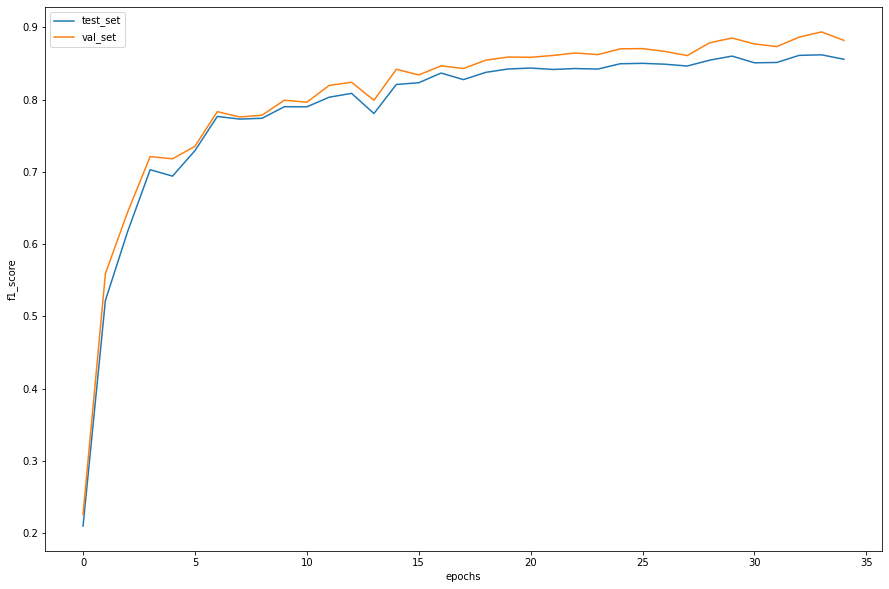

In [23]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(f1_test_history, label = "test_set")
plt.plot(f1_val_history, label = "val_set")
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.legend()
plt.show()

We see that with increase in the number of epoches, there is an increase in the f1 score for both test and val sets. This confirms that our model can generalize well to unknown examples. Also, it is important to note that if we increase the number of epochs for which we train the model from 35 to some big number, there is a good chance that the performance of the model will further increase. Howver, due to limitations in computational resources, we have kept the training epochs to 35.

We will save our mapping dictionaries as joblib files so that these can be used later to get the same results. The dictionary mappings might come out to be differnent for each time we train the model. Hence, it is necessary to save the mapping dictionaries that were generated while training the model.

In [19]:
for idx_dict, file_name in zip([tag2idx, word2idx, char2idx, case2idx], ['tag2idx.joblib', 'word2idx.joblib', 'char2idx.joblib', 'case2idx.joblib']):
    joblib.dump(idx_dict, f'./indexes/{file_name}')

print("Saved index_dicts as joblib files for future use.")

# **Model loading and testing**

**NOTE**: If we want to load the already trained model, we need to load the index dictionaries that are present in the indexes directory alongwith the trained model.

In [18]:
# We can either load the whole model from our saved trained model
model = load_model(f"./models/BiLSTM_CNN_{optimizer.__class__.__name__}.hdf5")

# OR

# We can build the model first and then load the trained weights
# model.load_weights(f"./models/BiLSTM_CNN_{optimizer.__class__.__name__}_weights.hdf5")

print("Trained model successfully initialized.")

# We also load the mapping dictionaries.
tag2idx = joblib.load(f'./indexes/tag2idx.joblib')
word2idx = joblib.load(f'./indexes/word2idx.joblib')
char2idx = joblib.load(f'./indexes/char2idx.joblib')
case2idx = joblib.load(f'./indexes/case2idx.joblib')

idx2tag_ = idx2tag
idx2tag = {v:k for k,v in tag2idx.items()}

Trained model successfully initialized.


We now randomly pick 5 examples from our test set and observe the predictions made by our trained model.

In [19]:
i = 27
preds, true = predict([test_set[i]])
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(test_set[i][0], true[0], preds[0]):
    print("{:15}: {:5} {}".format(idx2word[w], idx2tag_[t], idx2tag[pred]))

Word           ||True ||Pred
stefano        : B-PER B-PER
bordon         : I-PER I-PER
is             : O     O
out            : O     O
through        : O     O
illness        : O     O
and            : O     O
coste          : B-PER B-PER
said           : O     O
he             : O     O
had            : O     O
dropped        : O     O
back           : O     O
row            : O     O
corrado        : B-PER B-PER
UNK            : I-PER I-PER
,              : O     O
who            : O     O
had            : O     O
been           : O     O
recalled       : O     O
for            : O     O
the            : O     O
england        : B-LOC B-LOC
game           : O     O
after          : O     O
five           : O     O
years          : O     O
out            : O     O
of             : O     O
the            : O     O
national       : O     O
team           : O     O
.              : O     O


In the above example, we can clearly see that the model got all the entities correct. It is expected as our model had reached a high score on the evaluation metrics.

In [20]:
i = 1963
preds, true = predict([test_set[i]])
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(test_set[i][0], true[0], preds[0]):
    print("{:15}: {:5} {}".format(idx2word[w], idx2tag_[t], idx2tag[pred]))

Word           ||True ||Pred
plo            : B-ORG B-ORG
negotiators    : O     O
said           : O     O
on             : O     O
friday         : O     O
palestinian    : B-MISC B-MISC
president      : O     O
yasser         : B-PER B-PER
arafat         : I-PER I-PER
,              : O     O
israeli        : B-MISC B-MISC
prime          : O     O
minister       : O     O
benjamin       : B-PER B-PER
netanyahu      : I-PER I-PER
and            : O     O
egyptian       : B-MISC B-MISC
president      : O     O
hosni          : B-PER B-PER
mubarak        : I-PER I-PER
might          : O     O
all            : O     O
meet           : O     O
on             : O     O
saturday       : O     O
to             : O     O
try            : O     O
to             : O     O
clinch         : O     O
a              : O     O
deal           : O     O
on             : O     O
israel         : B-LOC B-LOC
's             : O     O
handover       : O     O
of             : O     O
hebron         : B-LO

In the above example as well, the model got all the entities correct. It could correctly identify the name of persons even though it might not have come across those words while training.

In [21]:
i = 189
preds, true = predict([test_set[i]])
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(test_set[i][0], true[0], preds[0]):
    print("{:15}: {:5} {}".format(idx2word[w], idx2tag_[t], idx2tag[pred]))

Word           ||True ||Pred
rugby          : B-ORG B-ORG
union          : I-ORG O
-              : O     O
little         : B-PER O
to             : O     O
miss           : O     O
campese        : B-PER B-PER
farewell       : O     O
.              : O     O


In the above example, we see that the model made an error for the word 'union'. The word 'union' is actually a part of the word 'Rugby Union'. However, the model failed to detect this particular entity. This is probably because union is a very generic word and the model failed to identify word based on its actual context use in the sentence. Other than that, the model also got 'little' wrong. In the true labels, it is tagged as a person. However because of the ambiguity around the word 'little', the model could not interpret the word correctly.

In [22]:
i = 297
preds, true = predict([test_set[i]])
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(test_set[i][0], true[0], preds[0]):
    print("{:15}: {:5} {}".format(idx2word[w], idx2tag_[t], idx2tag[pred]))

Word           ||True ||Pred
tasmania       : B-LOC B-LOC
352            : O     O
for            : O     O
three          : O     O
(              : O     O
david          : B-PER B-PER
boon           : I-PER I-PER
106            : O     O
not            : O     O
out            : O     O
,              : O     O
shaun          : B-PER B-PER
young          : I-PER I-PER
86             : O     O
not            : O     O
out            : O     O
,              : O     O
michael        : B-PER B-PER
divenuto       : I-PER I-PER
119            : O     O
)              : O     O
v              : O     O
victoria       : B-ORG O
.              : O     O


In the above example, the model got all entities correct expect for the word 'victoria' which is actually tagged as an organisation. This is again because the word 'victoria' is not very specific and could easily be taagged as a person in some other sentence as well dependng on the context of the word it is used in a sentence.

In [23]:
i = 936
preds, true = predict([test_set[i]])
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(test_set[i][0], true[0], preds[0]):
    print("{:15}: {:5} {}".format(idx2word[w], idx2tag_[t], idx2tag[pred]))

Word           ||True ||Pred
many           : O     O
of             : O     O
these          : O     O
citizens       : O     O
were           : O     O
jews           : B-MISC B-MISC
murdered       : O     O
during         : O     O
the            : O     O
war            : O     O
,              : O     O
when           : O     O
nazi           : B-MISC B-MISC
german         : B-MISC B-MISC
invaders       : O     O
killed         : O     O
most           : O     O
of             : O     O
poland         : B-LOC B-LOC
's             : O     O
3.5            : O     O
million        : O     O
jews           : B-MISC B-MISC
.              : O     O


In the example shown above, the model got all the entities correctly. Words like 'jews', 'nazi', 'german' were correctly identified. it is interesting to note that 'poland' was labelled as a location while 'german' was labelled as misc. So, the model is actually able to differentiate between countries ('poland') and something which is of a country ('german'). If the word 'germany' were to occur somewhere, the model would then have labelled it as a location.